## Particle Flow Filter Example using Lorenz 96 model

This simple example allows you to see the idea of the Particle Flow Filter, a fully nonlinear data assimilation method.

The PFF iteratively pushes forward a set of interacting particles from the prior $p(\mathbf{x})$ to samples from the posterior $p(\mathbf{x}|\mathbf{y})$ without any reweighting or resampling strategies. The PFF updates an ensemble of $N_p$ particles $\{\mathbf{x}^i \}^{N_p}_{i=1}$ via a gradient velocity field $\mathbf{f}: \mathbb{R}^{n_x}\rightarrow\mathbb{R}^{n_x}$ and follows the dynamics described by a set of ordinary coupled differential equations evolving over pseudo-time $s$. In practice, the PFF is solved in discrete dynamics for each particle:
\begin{equation}
    \mathbf{x}^i_{s+1}=\mathbf{x}^i_{s}+\Delta s\mathbf{f}(\mathbf{x}^i_{s}),
\end{equation}
where $\Delta s$ is the pseudo-time step and $\mathbf{x}^i_{s}$ is the $i^{th}$ particle at pseudo time $s$. The velocity field $\mathbf{f}$ for the $i^{th}$ particle at pseudo time $s$ is:
\begin{equation}
    \mathbf{f}(\mathbf{x}_s^i) = \frac{1}{N_p} \mathbf{B} \sum_{j=1}^{N_p} \left[ \mathbf{K}(\mathbf{x}_s^{i}, \mathbf{x}_s^{j}) \nabla_{\mathbf{x}_s^j} \log p(\mathbf{x}_s^{j} | \mathbf{y}) + \nabla_{\mathbf{x}_s^j} \cdot \mathbf{K}(\mathbf{x}_s^{i}, \mathbf{x}_s^{j}) \right],
\end{equation}
where $\mathbf{B}$ is the prior covariance and can be viewed as a preconditioning matrix, and $\mathbf{K}$ is a kernel matrix of size $n_x\times n_x$. Here, the kernel $\mathbf{K}$ characterizes the distance between any two particles.

The first term in the Equation acts as an attracting force that pushes the particles toward the mode of the posterior. The second term represents a repulsive force, pushing particles apart and creating separation within the kernel scale.

Note that the PFF operates similarly to an ensemble of 4D-Vars method, but particles can interact with each other through the kernel matrix during updates. When $N_p=1$, the particle flow reduced to standard variational methods.

This example will run PFF over a few data assimilation cycles. Try to:
1. Go through the whole process with assimilation of linear observation, then repeat the experiment with nonlinear observations to examine the impact of observation operator.
2. Set different numbers of iterations for PFF update.

Try thinking about:
1. What happens to the particles when we assimilate nonlinear observation?
2. What is the smallest number of iterations for which the RMSE of PFF becomes quasi-steady? Compare the experiment using linear observation with the one using nonlinear observation.

Import the libraries we need for the tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from numba import jit

### 1. Set up the Lorenz 96 model

$\frac{dx_{(a)}}{dt} = (x_{(a+1)} - x_{(a-2)})x_{(a-1)} - x_{(a)} + F$  
  
$x_{(a)}$: the a-th component of model state $x$  
  
$F$: the external forcing, set to a common value of 8  

Here, we set the number of state variables $x$ to be 100

In [2]:
# Lorenz 96 model parameters
Nx = 100  # Number of components
F = 8.0 * np.ones(Nx)  # Forcing term

# Function defining the Lorenz 96 model equations
# @jit(nopython=True)
def lorenz_96(x, F):
    dxdt = np.zeros_like(x)
    for i in range(Nx):
        dxdt[i] = (x[(i + 1) % Nx] - x[i - 2]) * x[i - 1] - x[i] + F[i]
    return dxdt

# Fourth-order Runge-Kutta integration
# @jit(nopython=True)
def runge_kutta4(x, F, dt):
    k1 = lorenz_96(x, F)
    k2 = lorenz_96(x + 0.5 * dt * k1, F)
    k3 = lorenz_96(x + 0.5 * dt * k2, F)
    k4 = lorenz_96(x + dt * k3, F)

    x_new = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_new

### 2. Set up the perfect model  experiments
#### 2.1 Nature run (true state)
Integrate the model for 2500 time steps. One model time step is set to be 0.01.

In [3]:
# Time parameters
timesteps = 2500
dt = 0.01

# Initial conditions
np.random.seed(0)
x0 = np.random.rand(Nx)

# Time integration
x_t = np.zeros((Nx, timesteps))
x_t[:, 0] = x0
for t in range(1, timesteps):
    if t == 1:
        for i in range(Nx):
            if np.mod(i+1, 5) == 0:
                F[i] = 9.0
            else:
                F[i] = 8.0
    else:
        F = 8.0 * np.ones(Nx)
    x_t[:, t] = runge_kutta4(x_t[:, t-1], F, dt)

Plot for the true state (e.g. the 0th component and the 72th component)

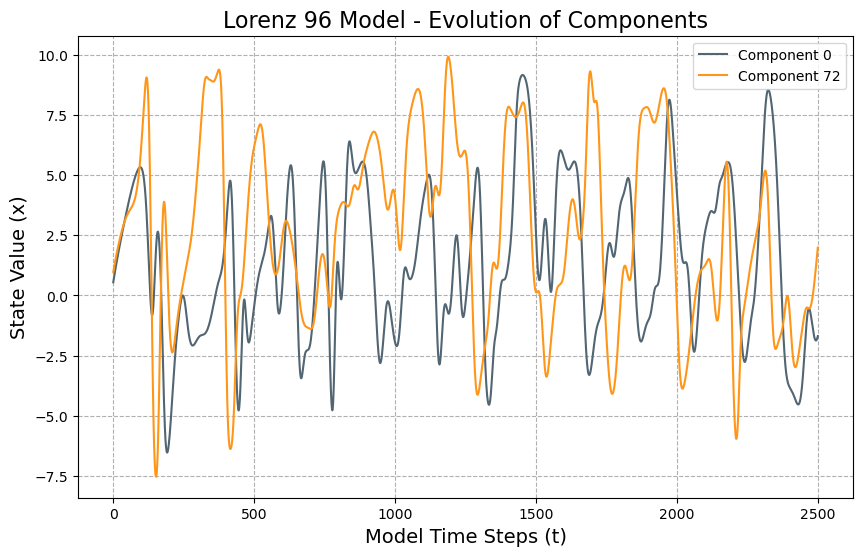

In [4]:
# Plotting

comp_sel1 = 0
comp_sel2 = 72

plt.figure(figsize=(10, 6))
plt.plot(x_t[comp_sel1, :], label=f'Component {comp_sel1}', color='#526573')
plt.plot(x_t[comp_sel2, :], label=f'Component {comp_sel2}', color='#ff9618')
plt.legend()
plt.grid(True, linestyle='--')
plt.title('Lorenz 96 Model - Evolution of Components', fontsize=16)
plt.xlabel('Model Time Steps (t)', fontsize=14)
plt.ylabel('State Value (x)', fontsize=14)
plt.show()

#### 2.2 Generate 20 ensemble members at the 1000th time step
The ensemble 20 ensemble members are generated after the spin-up period (1000 time steps) by perturbing the truth with Gaussian noise $\mathcal{N}(0,2\mathbf{I}_{{n_x}\times{n_x}})$

In [5]:
# Generate 20 ensemble members by adding random perturbations following a normal distribution (N,2)

# Generate ensemble members at model time step 1000
ens_start_time = 1000

# set the ensemble size
ensemble_size = 20

# set the seed
np.random.seed(1)

# mean and standard deviation
mu, sigma = 0, np.sqrt(2)

# initialize an empty list to hold the sets of random numbers
random_numbers_sets = []

# generate 1000 sets of 20 random numbers
for _ in range(Nx):
    random_numbers = np.random.normal(mu, sigma, ensemble_size)
    random_numbers_sets.append(random_numbers)

# now random_numbers_sets is a list of 1000 arrays, each containing 20 random numbers

prior_ens_0 = np.zeros((Nx, ensemble_size))
prior_ens_0 = np.tile(x_t[:, ens_start_time], (ensemble_size,1)).T + np.array(random_numbers_sets) # (N,20)

#### 2.3 Generate observations every 20 model time step

Select an observation type:  
1. linear: $H(x)=x$  
2. square: $H(x)=x^2$ (nonlinear observation)

In [6]:
obs_type = 'linear'   # Please type ['linear', 'square']

Generate observations every 20 model time step by adding Gaussian noise $\mathcal{N}(0,\mathbf{R})$ to the observation operator working on the truth.  
$\mathbf{R}=\epsilon \mathbf{I}_{{n_y}\times{n_y}}$, where $\epsilon$ is the observational error variance and $n_y$ is the number of observations. The observation consists of $n_y=\frac{1}{4}n_x$ uniformly distributed measurements, sampling every fourth variable in the system ($25\%$ of the system is observed). The observation frequency here (20 model time steps) is similar to the data assimilation for atmospheric models every 24 hours.

In [7]:
# Generate 75 sets of 250 observation by adding random perturbations following a normal distribution (N,obs_eps)

Ny = Nx//4  # Number of observations
assim_period = 20  # Do the assimilation every 20 time steps

# Observation error standard deviation
if obs_type == 'linear':
    obs_eps = 0.5
elif obs_type == 'square':
    obs_eps = 1.0
# obs_eps = 1.0

# set the number of observation sets
Number_of_obs_sets = int((timesteps-ens_start_time)/assim_period)

# set the seed
np.random.seed(2)
# mean and standard deviation
mu, sigma = 0, np.sqrt(obs_eps)

# initialize an empty list to hold the sets of random numbers
random_numbers_sets = []

# generate 250 sets of "Number_of_obs_sets" random numbers
for _ in range(Ny):
    random_numbers = np.random.normal(mu, sigma, Number_of_obs_sets)
    random_numbers_sets.append(random_numbers)

# now random_numbers_sets is a list of 250 arrays, each containing "Number_of_obs_sets" random numbers

obs_set = np.zeros((Ny, Number_of_obs_sets))
if obs_type == 'linear':
    obs_set = x_t[::4, ens_start_time::assim_period] + np.array(random_numbers_sets)
elif obs_type == 'square':
    obs_set = np.square(x_t[::4, ens_start_time::assim_period]) + np.array(random_numbers_sets)

Plot for the initial ensemble at the 1000th time step (denoted "t = 0") and all the observations for one of the observed variable, e.g., the 72th component.

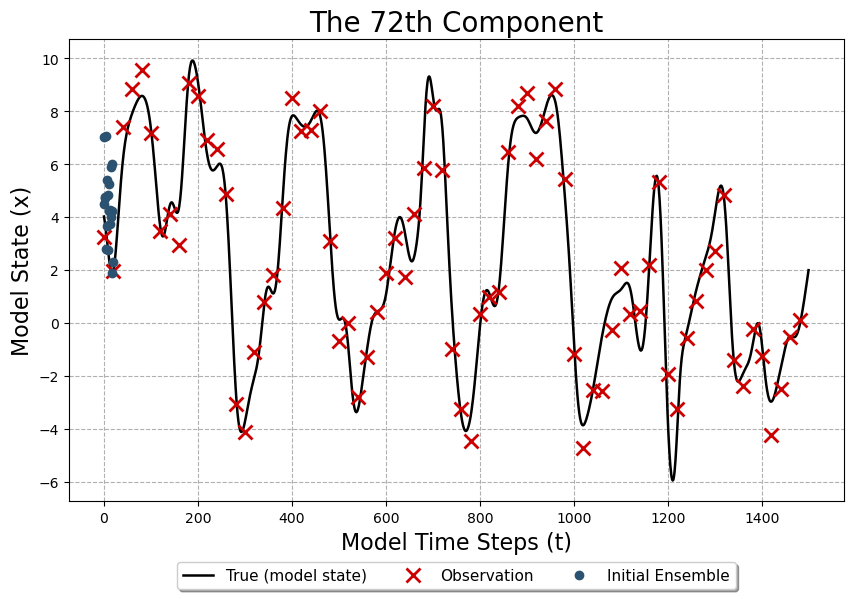

In [8]:
comp_sel = 72

plt.figure(figsize=(10, 6))
plt.plot(x_t[comp_sel, ens_start_time::], label='True (model state)', color='k', linewidth=1.8)
obs_full = np.full((timesteps-ens_start_time),np.nan)
for i in range(Number_of_obs_sets):
    obs_full[i*assim_period] = obs_set[comp_sel//4,i]
plt.plot(obs_full, 'x', label='Observation', color='#CC0000', markeredgewidth=2, markersize=10)
plt.plot(prior_ens_0[comp_sel, :], 'o', label='Initial Ensemble', c='#2b5270')
plt.grid(True, linestyle='--')
# legend = plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.legend(loc='center', fontsize=11, bbox_to_anchor=(0.5, -0.16), ncol=4, fancybox=True, shadow=True)
plt.title(f'The {comp_sel}th Component', fontsize=20)
plt.xlabel('Model Time Steps (t)', fontsize=16)
plt.ylabel('Model State (x)', fontsize=16)
plt.show()

### 3. Particle Flow Filter (PFF)  
#### 3.1 The PFF code

In [9]:
# The Deterministic Particle Flow Filter
def PFF(prior_ens, y, obs_eps, ensemble_size, iter_num, alpha, ds):

    # Input to the algorithm
    R_matrix = np.eye(Ny) * obs_eps  #(Ny,Ny)
    R_matrix_inv = np.linalg.inv(R_matrix)

    # Assume a Gaussian prior in this pseudo code
    prior_mean = np.mean(prior_ens, axis=1)  #(Nx,)

    # generate ensemble perturbation matrix
    ens_perturb = prior_ens - np.tile(prior_mean, (ensemble_size,1)).T  #(Nx,ensemble_size)

    # generate ensemble covariance matrix
    prior_cov = np.matmul(ens_perturb, ens_perturb.T) / (ensemble_size - 1)  #(Nx,Nx)

    # localization

    # generate a distance matrix
    r_in = 4    #decorrelation length scale
    i, j = np.meshgrid(np.arange(Nx), np.arange(Nx), indexing='ij')
    dist_matrix = np.exp(-np.square(np.abs(i - j)/r_in))

    prior_cov = prior_cov*dist_matrix  #(Nx,Nx)
    prior_cov_inv = np.linalg.inv(prior_cov) #(Nx,Nx)

    xs_r = np.zeros((Nx, ensemble_size, iter_num+1))
    xs = prior_ens.copy()  #(Nx,ensemble_size)
    xs_r[:,:,0] = xs.copy()

    # iter_norm_less = 0
    iter_norm_large = 0
    norm_2 = np.zeros((iter_num+1))
    s = 0
    # if s < iter_num:
    for iter in range(1000):
        gradient_log_post = np.zeros((Nx, ensemble_size))
        for i in range(ensemble_size):
            # modeled observation

            if obs_type == 'linear':
                yb = xs[::4, i]
                H = np.zeros((Ny, Nx))
                # linearized observation operator
                for j in range(Ny):
                    H[j, 4*j] = 1
            elif obs_type == 'square':
                yb = np.square(xs[::4, i])
                H = np.zeros((Ny, Nx))
                # linearized observation operator
                for j in range(Ny):
                    H[j, 4*j] = 2*xs[::4, i][j]

            # gradient of log posterior
            gradient_log_post[:, i] = np.matmul(np.matmul(H.T, R_matrix_inv), (y - yb))- np.matmul(prior_cov_inv, (xs[:, i]-prior_mean)) #(Nx,)

        I = np.zeros((Nx, ensemble_size))

        d, i, j = np.meshgrid(np.arange(Nx), np.arange(ensemble_size), np.arange(ensemble_size), indexing='ij')
        K = np.exp(-0.5*np.square((xs[d, i]-xs[d, j]))/(alpha*prior_cov[d, d]))
        dK = (xs[d, i]-xs[d, j])/(alpha*prior_cov[d, d])*K
        I = np.sum((K*gradient_log_post[d, j]+dK)/ensemble_size, axis=-1)

        norm_2[s] = np.linalg.norm(I)
        fs = np.matmul(prior_cov, I)
        # print(fs)
        # print(norm_2[s], norm_2[s-1])

        # Apply the adaptive step size (learning rate)

        if s == 0:
            xs_r[:,:,s+1] = xs_r[:,:,s] + ds*fs
            s = s+1
            iter_norm_large += 1
            xs = xs_r[:,:,s].copy()
        elif s >=1 and norm_2[s] > 1.02*norm_2[s-1]:
            ds = ds/1.5
            s = s-1
            xs = xs_r[:,:,s].copy()
            iter_norm_large = 0
            # print('[Note] The eps has been changed to ', ds, '... Redo the PFF based on this eps')
        elif iter_norm_large >= 7 and norm_2[s] <= 1.02*norm_2[s-1]:
            ds = ds*1.5
            xs_r[:,:,s+1] = xs_r[:,:,s] + ds*fs
            s = s+1
            iter_norm_large = 0
            xs = xs_r[:,:,s].copy()
        else:
            xs_r[:,:,s+1] = xs_r[:,:,s] + ds*fs
            s = s+1
            iter_norm_large += 1
            xs = xs_r[:,:,s].copy()

        # print('iter = ', iter)
        # xs_r[:,:,iter+1] = xs.copy()
        # print('iter = ', s)
        # print('ds = ', ds)

        # print(np.max(np.abs(xs)))
        if s >= iter_num:
            # print('The PFF has been terminated after ', s, ' iterations')
            break
    return xs , xs_r

#### 3.2 Running the sequential DA experiment with PFF (observations are assimilated every 20 model time step)
Set the number of iterations

In [ ]:
iter_num = 300      #number of iterations

Run the model

In [ ]:
# Fixed parameters for model and PFF
integration_time_step = 500
F = 8.0 * np.ones(Nx)
alpha = 1/ensemble_size    # the width of the kernel

if obs_type == 'linear':
    ds = 0.05           # step size
elif obs_type == 'square':
    ds = 0.001

# Initial conditions
prior_ens_PFF = np.zeros((Nx, ensemble_size, int(integration_time_step/assim_period)+1))
posterior_ens_PFF = np.zeros((Nx, ensemble_size, int(integration_time_step/assim_period)+1))
x_PFF = np.zeros((Nx, ensemble_size, integration_time_step+1))

posterior_ens_PFF[:,:,0] = prior_ens_0.copy()  #(Nx,ensemble_size)
x_PFF[:,:,0] = prior_ens_0.copy()  #(Nx,ensemble_size)

# Sequential DA for PFF with 20 time-steps frequency
for t in range(1, integration_time_step+1):
# for t in range(1, integration_time_step):

    # Model integration
    for i in range(ensemble_size):
        x_PFF[:, i, t] = runge_kutta4(x_PFF[:, i, t-1], F, dt)

    if np.mod(t, assim_period) == 0:
        print("Implement PFF at time step ", t, " ...")

        # set the prior ensemble at the assimilation time
        prior_ens_PFF[:, :, int(t/assim_period)] = x_PFF[:, :, t]

        # run the PFF algorithm
        [posterior_ens_PFF[:,:,int(t/assim_period)], xs_r] = PFF(prior_ens_PFF[:, :, int(t/assim_period)], obs_set[:, int(t/assim_period)], obs_eps, ensemble_size, iter_num, alpha, ds)

        # update the model state by posterior ensemble
        x_PFF[:, :, t] = posterior_ens_PFF[:,:,int(t/assim_period)]

        # save the ensemble trajectory during the first assimilation period
        if t == assim_period*1:
            xs_r1 = xs_r.copy()


Implement PFF at time step  20  ...
Implement PFF at time step  40  ...
Implement PFF at time step  60  ...
Implement PFF at time step  80  ...
Implement PFF at time step  100  ...
Implement PFF at time step  120  ...
Implement PFF at time step  140  ...
Implement PFF at time step  160  ...
Implement PFF at time step  180  ...
Implement PFF at time step  200  ...
Implement PFF at time step  220  ...
Implement PFF at time step  240  ...
Implement PFF at time step  260  ...
Implement PFF at time step  280  ...
Implement PFF at time step  300  ...
Implement PFF at time step  320  ...
Implement PFF at time step  340  ...
Implement PFF at time step  360  ...
Implement PFF at time step  380  ...
Implement PFF at time step  400  ...
Implement PFF at time step  420  ...
Implement PFF at time step  440  ...
Implement PFF at time step  460  ...
Implement PFF at time step  480  ...
Implement PFF at time step  500  ...


### 4. Let's check the results
#### 4.1 Updating process of the ensemble members for the first assimilation

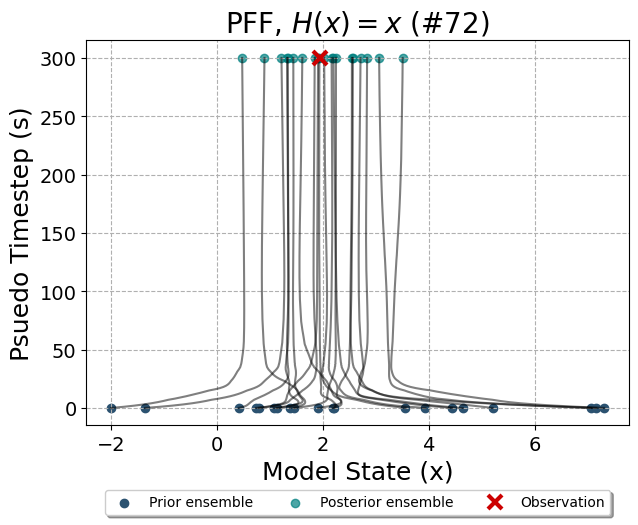

In [11]:
# comp_sel = 760
comp_sel = 72
plt.figure(figsize=(7, 5))
for i in range(ensemble_size):
    plt.plot(xs_r1[comp_sel, i, :], range(len(xs_r1[comp_sel, i, :])), 'k', alpha=0.5)
plt.scatter(xs_r1[comp_sel, :, 0], 0*np.ones(ensemble_size), c='#2b5270', label='Prior ensemble')
plt.scatter(xs_r1[comp_sel, :, iter_num], iter_num*np.ones(ensemble_size), c='#008080', label='Posterior ensemble', alpha=0.7)

if obs_type == 'linear':
    plt.plot(obs_set[comp_sel//4, 1], iter_num, 'x', markeredgewidth=3, markersize=10, color='#CC0000', label='Observation')
    plt.title(f'PFF, $H(x)=x$ (#{comp_sel})', fontsize=20)
elif obs_type == 'square':
    plt.plot(x_t[comp_sel, ens_start_time+1*assim_period], iter_num, 'x', markeredgewidth=3, markersize=10, color='#CC0000', label='Truth')
    plt.plot(-x_t[comp_sel, ens_start_time+1*assim_period], iter_num, 'x', markeredgewidth=3, markersize=10, color='#004C99', label='Opposite sign of Truth')
    plt.title(f'PFF, $H(x)=x^2$ (#{comp_sel})', fontsize=20)

# plt.xlim(-10, 10)
plt.legend(loc='center', fontsize=10, bbox_to_anchor=(0.5, -0.2), ncol=4, fancybox=True, shadow=True)
plt.xlabel('Model State (x)', fontsize=18)
plt.ylabel('Psuedo Timestep (s)', fontsize=18)
plt.tick_params(labelsize=14)
plt.grid(True, linestyle='--')
plt.show()

#### 4.2 Evolution of the ensemble members

Here, we run the experiment without DA (NoDA) and compare it with the PFF

In [12]:
# NoDA

# Initial conditions
x_PFF_NoDA = np.zeros((Nx, ensemble_size, integration_time_step+1))
x_PFF_NoDA[:,:,0] = prior_ens_0.copy()  #(Nx,ensemble_size)

# Time integration
for t in range(1, integration_time_step):
    for i in range(ensemble_size):
        x_PFF_NoDA[:, i, t] = runge_kutta4(x_PFF_NoDA[:, i, t-1], F, dt)

Evolution of NoDA ensemble

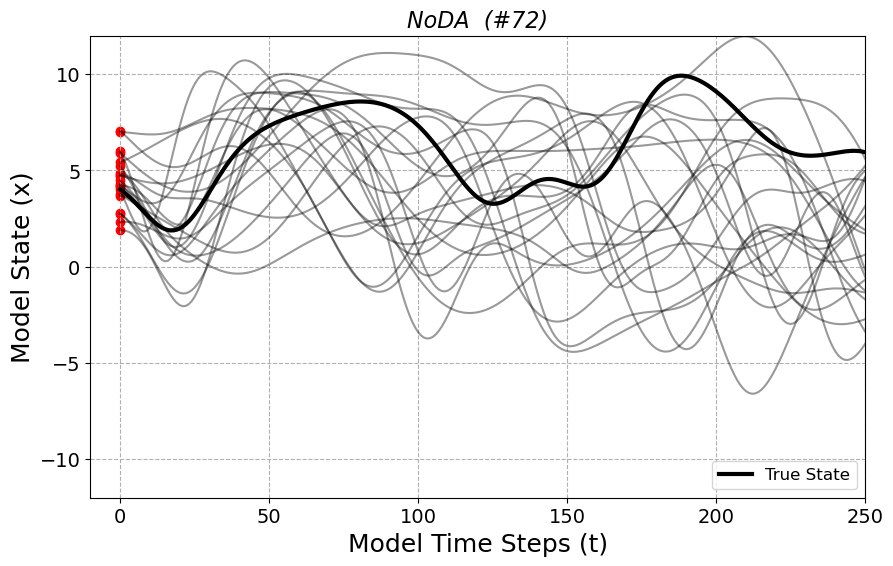

In [13]:
plt.figure(figsize=(10, 6))  # Set the figure size to 10 inches wide and 6 inches tall
comp_sel = 72

plt.plot(x_t[comp_sel, ens_start_time::], 'k', label='True State', linewidth=3)
for i in range(ensemble_size):
    plt.plot(x_PFF_NoDA[comp_sel, i, 0:integration_time_step+1], 'k', alpha=0.4, linewidth=1.5)
# plt.scatter(0*np.ones(ensemble_size), x_PFF[comp_sel, :, 0], c='r')
plt.scatter(0*np.ones(ensemble_size), prior_ens_0[comp_sel], c='r')


plt.xlim(-10, 250)
# plt.xlim(250, 500)
# plt.xlim(-10, 500)
plt.ylim(-12, 12)
plt.title(f'NoDA  (#{comp_sel})', fontsize=16, style='italic')
plt.xlabel('Model Time Steps (t)', fontsize=18)
plt.ylabel('Model State (x)', fontsize=18)
plt.tick_params(labelsize=14)
plt.grid(True, linestyle='--')
legend = plt.legend(fontsize=12, loc='lower right')
plt.show()

Ensemble evolution of PFF

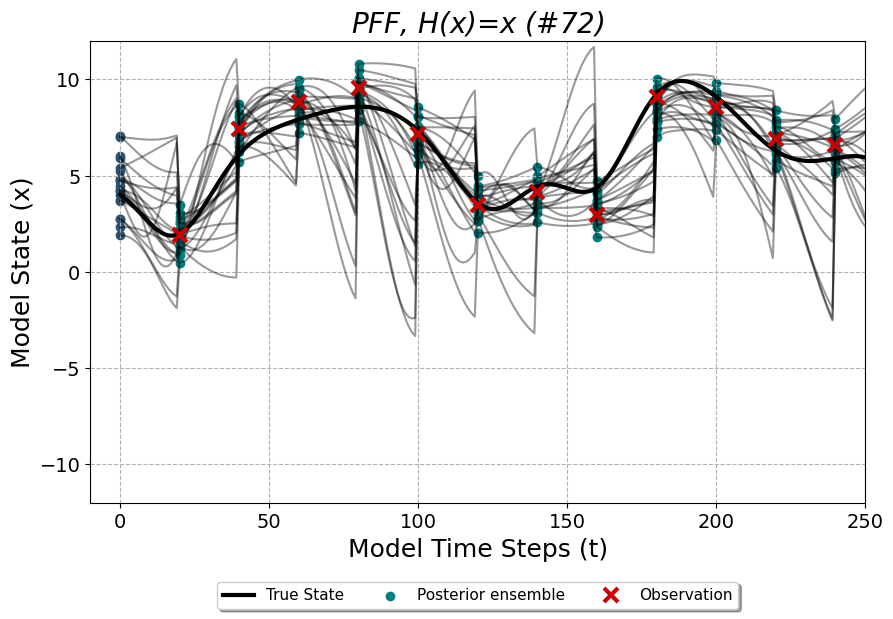

In [14]:
plt.figure(figsize=(10, 6))
comp_sel = 72

plt.plot(x_t[comp_sel, ens_start_time::], 'k', label='True State', linewidth=3)
for i in range(ensemble_size):
    plt.plot(x_PFF[comp_sel, i, 0:integration_time_step+1], 'k', alpha=0.4, linewidth=1.5)
plt.scatter(0*np.ones(ensemble_size), x_PFF[comp_sel, :, 0], c='#2b5270')

for i in range(1,int(integration_time_step//assim_period)+1):
    plt.scatter(i*assim_period*np.ones(ensemble_size), posterior_ens_PFF[comp_sel, :, int(i*assim_period/assim_period)], c='#008080',\
            label='Posterior ensemble' if i == 1 else "")
    if obs_type == 'linear':
        plt.plot(i*assim_period, obs_set[comp_sel//4, i*assim_period//assim_period], 'x', markeredgewidth=3, markersize=10, color='#CC0000',\
        label='Observation' if i == 1 else "")
        plt.title(f'PFF, H(x)=$x$ (#{comp_sel})', fontsize=20, style='italic')
    elif obs_type == 'square':
        plt.plot(i*assim_period, x_t[comp_sel, ens_start_time+i*assim_period], 'x', markeredgewidth=3, markersize=10, color='#CC0000', label='Truth' if i == 1 else "")
        plt.plot(i*assim_period, -x_t[comp_sel, ens_start_time+i*assim_period], 'x', markeredgewidth=3, markersize=10, color='#004C99', label='Opposite sign of Truth' if i == 1 else "")
        plt.title(f'PFF, H(x)=$x^2$ (#{comp_sel})', fontsize=20, style='italic')

plt.xlim(-10, 250)
# plt.xlim(250, 500)
# plt.xlim(-10, 500)
plt.ylim(-12, 12)
plt.xlabel('Model Time Steps (t)', fontsize=18)
plt.ylabel('Model State (x)', fontsize=18)
plt.tick_params(labelsize=14)
plt.grid(True, linestyle='--')
plt.legend(loc='center', fontsize=11, bbox_to_anchor=(0.5, -0.2), ncol=4, fancybox=True, shadow=True)
plt.show()

#### 4.3 Root-mean-square error (RMSE) and ensemble spread

Plot for RMSE and ensemble spread (at observation space)

2.5468648632835977 (Avg. Spread of PFF prior)
1.9658311377867803 (Avg. RMSE of PFF prior)
0.5735962677882849 (Avg. RMSE of PFF posterior)


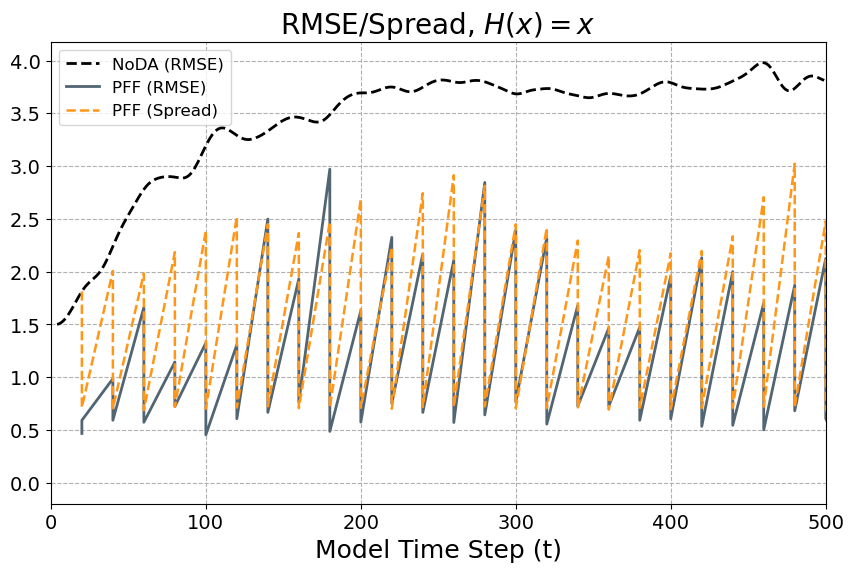

In [15]:
Output_list = ['PFF']

adjust_factor = np.sqrt((ensemble_size+1)/ensemble_size)

if obs_type == 'linear':
    x_t_obs_space = x_t[::4, ens_start_time::assim_period]
    x_t_obs_space_full = x_t[::4, ens_start_time::]
    x_PFF_NoDA_obs_space = x_PFF_NoDA[::4, :, :]
elif obs_type == 'square':
    x_t_obs_space = np.square(x_t[::4, ens_start_time::assim_period])
    x_t_obs_space_full = np.square(x_t[::4, ens_start_time::])
    x_PFF_NoDA_obs_space = np.square(x_PFF_NoDA[::4, :, :])

# Exponential operator
# x_t_obs_space = np.exp(x_t[::4, ens_start_time::assim_period]/6)
# x_t_obs_space_full = np.exp(x_t[::4, ens_start_time::]/6)
# x_PFF_NoDA_obs_space = np.exp(x_PFF_NoDA[::4, :, :]/6)

x_PFF_NoDA_ens_mean = np.mean(x_PFF_NoDA_obs_space, axis=1)
rmse_NoDA = np.sqrt(np.mean((x_PFF_NoDA_ens_mean[:,4:integration_time_step] - x_t_obs_space_full[:,4:integration_time_step])**2, axis=0))
spread_NoDA = adjust_factor*np.sqrt(np.mean(np.var(x_PFF_NoDA_obs_space[:, :, 4:integration_time_step], axis=1, ddof=1), axis=0))

t_NoDA = np.arange(4, integration_time_step)
t = np.arange(1, Number_of_obs_sets)
tt = assim_period*np.repeat(t, 2)

plt.figure(figsize=(10, 6))
plt.plot(t_NoDA,spread_NoDA, label='NoDA (RMSE)', linewidth=2, color='k', linestyle='--')

for i in range(len(Output_list)):

    if obs_type == 'linear':
        prior_ens_obs_space = prior_ens_PFF[::4, :, :]
        posterior_ens_obs_space = posterior_ens_PFF[::4, :, :]
    elif obs_type == 'square':
        prior_ens_obs_space = np.square(prior_ens_PFF[::4, :, :])
        posterior_ens_obs_space = np.square(posterior_ens_PFF[::4, :, :])

    # Exponential operator
    # prior_ens_obs_space = np.exp(prior_ens_PFF[::4, :, :]/6)
    # posterior_ens_obs_space = np.exp(posterior_ens_PFF[::4, :, :]/6)

    prior_ens_mean = np.mean(prior_ens_obs_space, axis=1)
    posterior_ens_mean = np.mean(posterior_ens_obs_space, axis=1)

    rmse_prior = np.sqrt(np.mean((prior_ens_mean[:,1:Number_of_obs_sets] - x_t_obs_space[:,1:int(integration_time_step//assim_period)+1])**2, axis=0))
    rmse_posterior = np.sqrt(np.mean((posterior_ens_mean[:,1:Number_of_obs_sets] - x_t_obs_space[:,1:int(integration_time_step//assim_period)+1])**2, axis=0))

    spread_prior = adjust_factor*np.sqrt(np.mean(np.var(prior_ens_obs_space[:, :, 1:Number_of_obs_sets], axis=1, ddof=1), axis=0))
    spread_posterior = adjust_factor*np.sqrt(np.mean(np.var(posterior_ens_obs_space[:, :, 1:Number_of_obs_sets], axis=1, ddof=1), axis=0))

    rmse_timeseries = np.zeros(((Number_of_obs_sets-1)*2))
    rmse_timeseries[0:(int(integration_time_step//assim_period)*2):2] = rmse_prior
    rmse_timeseries[1:(int(integration_time_step//assim_period)*2):2] = rmse_posterior
    spread_timeseries = np.zeros(((Number_of_obs_sets-1)*2))
    spread_timeseries[0:(int(integration_time_step//assim_period)*2):2] = spread_prior
    spread_timeseries[1:(int(integration_time_step//assim_period)*2):2] = spread_posterior

    plt.plot(tt,rmse_timeseries, label=f'{Output_list[i]} (RMSE)', linewidth=2, color='#526573')
    plt.plot(tt,spread_timeseries, label=f'{Output_list[i]} (Spread)', linewidth=1.8, linestyle='--', color='#ff9618')

    print(np.mean(spread_prior[20::]), f'(Avg. Spread of {Output_list[i]} prior)')
    print(np.mean(rmse_prior[20::]), f'(Avg. RMSE of {Output_list[i]} prior)')
    print(np.mean(rmse_posterior[20::]), f'(Avg. RMSE of {Output_list[i]} posterior)')
    # print(np.mean(spread_prior[20::])-np.mean(rmse_prior[20::]), '(Difference)')

# plt.ylim(-0.3, 31)
plt.xlim(-0.1, 500)
plt.xlabel('Model Time Step (t)', fontsize=18)
if obs_type == 'linear':
    plt.title('RMSE/Spread, $H(x)=x$', fontsize=20)
elif obs_type == 'square':
    plt.title('RMSE/Spread, $H(x)=x^2$', fontsize=20)
legend = plt.legend(fontsize=12, loc='upper left')
plt.tick_params(labelsize=14)
plt.grid(True, linestyle='--')

plt.show()